In [1]:
from PINN.pinn_solver import PINNSolver
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd


# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback


DTYPE = 'float32'
tf.random.set_seed(12345)
np.random.seed(12345)


class SPINN(PINNSolver):
    def __init__(self, x_r, u_r, s1, s2, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Store Model Variables
        self.K = 1.0
        self.tau = 2.0
        # Store Model Constants

        # Store collocation points
        self.x_r = x_r
        self.u = u_r
        self.s1 = s1
        self.s2 = s2
        self.dt = 1
        
    @tf.function
    def get_residual_loss(self):
    #     with tf.GradientTape(persistent=True) as tape:
    #         # Watch variables representing t and x during this GradientTape
    #         # tape.watch(self.t)

    #         # Compute current values y(t,x)
        y = self.model(self.x_r)
            
    #         # y_t = tape.gradient(y, self.t)
    #     # y_tt = tape.gradient(y_t, self.t)

    #     del tape

        return self.residual_function(self.u, y)

    def residual_function(self, u, y_nn):
        """Residual of the ODE"""
        # y = self.s2.inverse_transform(y_nn)
        y = (y_nn+1)/2 * (self.s2.data_max_[0]-self.s2.data_min_[0])+self.s2.data_min_[0]

        # res = y_tt + self.mu*y_t + self.k*y
        # y = self.model(self.Xs[:])
        y_t = (y[1:]-y[:-1]) / self.dt
        y = y[0:-1]
        u = u[0:-1]
        res = self.tau * y_t + y - self.K * u
        # res[0] -= qh
        # return y_t/3000.0*100.0 - self.model.alpha * y_xx/(0.1-0.001)**2*100 + self.model.beta * (y*100+20 - self.Ts)
        return 1e1*res

    def callback(self, *args):
        if self.iter % 10 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss)
                  )
        self.hist.append(self.current_loss)
        self.iter += 1


In [2]:
# Load Data
data1 = pd.read_pickle('open_loop_data_SISO-test.pkl')
# data = data[0:100]

window = 5


# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
s1.data_max_ = np.array([2])
s1.data_min_ = np.array([0])
s1.min_ = np.array([-1])
s1.max_ = np.array([1])
s1.data_range_ = np.array([2])
s1.scale_ = np.array([1])
Xs = s1.transform(data1[['u']].to_numpy())

s2 = MinMaxScaler(feature_range=(-1,1))
s2.data_max_ = np.array([2])
s2.data_min_ = np.array([0])
s2.data_range_ = np.array([2])
s2.min_ = np.array([-1])
s2.max_ = np.array([1])
s2.scale_ = np.array([1])
Ys = s2.transform(data1[['y']].to_numpy())

# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param.pkl', 'wb'))

nstep = Xs.shape[0]
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print("Training:",cut_index, ", Validation:", nstep-cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

X_train = []
Y_train = []
for i in range(window,len(Xs_train)):
    X_train.append(Xs_train[i-window:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)):
    X_val.append(Xs_val[i-window:i,:])
    Y_val.append(Ys_val[i])

# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)


Training: 800 , Validation: 800


/var/folders/cp/p82kw9zd4psdb4vl1wp3x09m0000gn/T/ipykernel_53377/803593059.py:37: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set


In [3]:
np.min(Xs), np.max(Xs)

(-1.0, -0.007339853469999991)

In [4]:
# # Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=Y_train.shape[1])) #units = number of outputs
# model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
            #   metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# # Fit (and time) LSTM model
# t0 = time.time()
# result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 250,\
#                              callbacks=[es_lstm, TqdmCallback(verbose=1)],\
#                              verbose=0, validation_data=(X_val, Y_val))
# t1 = time.time()
# print('Runtime: %.2f s' %(t1-t0))


# layers = [1, 32, 32, 32, 1]

# # Input Layer
# model.add(tf.keras.layers.InputLayer(input_shape=(layers[0])))

# # Hidden Layers
# for n_i in range(1, len(layers) - 1):
#     model.add(tf.keras.layers.Dense(units=layers[n_i],
#                                     activation='tanh',
#                                     kernel_initializer='glorot_normal')
#               )

# model.add(tf.keras.layers.Dense(units=layers[-1], kernel_initializer='glorot_normal')
#           )


# x_physics = x[::5][:, None]
# y_physics = y[::5][:, None]
# x_physics = tf.convert_to_tensor(x_physics.numpy(), dtype=DTYPE)
# y_physics = tf.convert_to_tensor(y_physics.numpy(), dtype=DTYPE)

# x_physics = data["u"]
# y_physics = data["y"]
# x_physics = tf.convert_to_tensor(x_physics.numpy(), dtype=DTYPE)
# y_physics = tf.convert_to_tensor(y_physics.numpy(), dtype=DTYPE)

u_r = data1["u"].to_numpy()[window:Xs_train.shape[0],None]
u_r = tf.convert_to_tensor(u_r, DTYPE)


solver = SPINN(model=model_lstm, x_r=X_train,u_r=u_r, s1=s1, s2=s2, is_pinn=True)

# # Choose step sizes aka learning rate
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000], [1e-3, 1e-4, 1e-5])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam()

X_train = tf.convert_to_tensor(X_train, DTYPE)
Y_train = tf.convert_to_tensor(Y_train, DTYPE)



2022-05-24 17:22:27.243925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-24 17:22:27.244047: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [5]:
# PINN Off

# solver.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=300)M
solver.is_pinn = False
solver.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=300)

# solver.solve_with_scipy_optimizer(X_train, Y_train, method='L-BFGS-B')
# solver.solve_with_scipy_optimizer(x_physics, y_physics, method='SLSQP')

2022-05-24 17:22:30.056610: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-24 17:22:30.060824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 17:22:30.115247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node zeros_like_20 was passed float from sequential/lstm/PartitionedCall:6 incompatible with expected variant.
2022-05-24 17:22:30.139367: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] tfg_optimizer{} failed: INVALID_ARGUMENT: Input 0 of node zeros_like_20 was passed float from sequential/lstm/PartitionedCall:6 incompatible with expected variant.
	when importing GraphDef to MLIR module in GrapplerHook
2022-05-24 17:22:30.144173: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:828] function_optimizer failed: INVALID_ARGUMENT: Input 0 of node zeros_lik

It 00000: loss = 3.24308008e-01
It 00010: loss = 5.33294156e-02
It 00020: loss = 3.50390933e-02
It 00030: loss = 2.14296803e-02
It 00040: loss = 1.69962514e-02
It 00050: loss = 1.43778445e-02
It 00060: loss = 1.30734518e-02
It 00070: loss = 1.25697106e-02
It 00080: loss = 1.23691410e-02
It 00090: loss = 1.20737059e-02
It 00100: loss = 1.17736319e-02
It 00110: loss = 1.14622703e-02
It 00120: loss = 1.11124245e-02
It 00130: loss = 1.07195033e-02
It 00140: loss = 1.02694603e-02
It 00150: loss = 9.74216312e-03
It 00160: loss = 9.10778902e-03
It 00170: loss = 8.32349621e-03
It 00180: loss = 7.34245125e-03
It 00190: loss = 6.16657268e-03
It 00200: loss = 4.98390431e-03
It 00210: loss = 4.23703529e-03
It 00220: loss = 4.06055246e-03
It 00230: loss = 3.92012438e-03
It 00240: loss = 3.75016825e-03
It 00250: loss = 3.60805169e-03
It 00260: loss = 3.45878117e-03
It 00270: loss = 3.30292247e-03
It 00280: loss = 3.14224372e-03
It 00290: loss = 2.97765667e-03


In [6]:
#%% Save LSTM model file
solver.model.save('PINN_FOPDT_onestep_LSTM_pinn_off.h5')

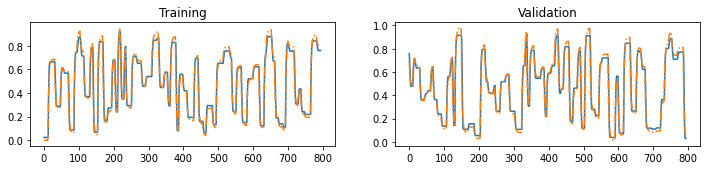

In [7]:
# Training results
yp_train = solver.model(X_train)
y_pinn_train = s2.inverse_transform(yp_train)

yp_val = solver.model(X_val)
y_pinn_val = s2.inverse_transform(yp_val)


plt.figure(figsize=(12,5))
plt.subplot(2,2,1)
plt.gca().set_title('Training')
plt.plot(y_pinn_train)
plt.plot(data1["y"].to_numpy()[window:y_pinn_train.shape[0]], '-.')


plt.subplot(2,2,2)
plt.gca().set_title('Validation')
plt.plot(y_pinn_val)
plt.plot(data1["y"].to_numpy()[y_pinn_train.shape[0]+window+window:], '-.')


plt.show()

## Using predicted values to predict next step

In [8]:
# Load the other Dataset with larger range
data2 = pd.read_pickle('open_loop_data_SISO.pkl')

# Select a Data Range to show
# data2 = data2[500:800]

# Scale
Xs = s1.transform(data2[['u']].to_numpy())
Ys = s2.transform(data2[['y']].to_numpy())

# Make snapshots
X_val = []
Y_val = []
for i in range(window,len(Xs)):
    X_val.append(Xs[i-window:i,:])
    Y_val.append(Ys[i])
    
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

In [9]:
Xsq = Xs.copy()   # Xs : scaled data before appending the array with window size
Ysq = Ys.copy()
for i in range(window,len(Xsq)):
    Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
    Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = solver.model.predict(Xin) 
    # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
    # first 'system' output variable in the 'LSTM' input array
    Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]

Ytu = s2.inverse_transform(Ysq)
# Break Ytu into train and validation set for plotting
Ytu_val_lstm = Ytu

Ym_val = s2.inverse_transform(Y_val)

2022-05-24 17:23:15.048509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 17:23:15.139308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 17:23:15.175161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-24 17:23:15.202588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


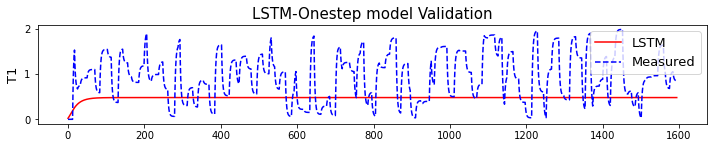

In [10]:
plt.figure(0, figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(Ytu_val_lstm[window:],'r-',label='LSTM')
plt.plot(Ym_val,'b--',label='Measured')
plt.title('LSTM-Onestep model Validation',fontsize=15)
plt.ylabel("T1", fontsize=13)
plt.legend(loc=1,fontsize=13)
plt.show()